In [1]:
#Library Imports
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.USPS(root='usps', download=True, transform=ToTensor(), train=True)
test_data = datasets.USPS(root='usps', download=True, transform=ToTensor(), train=False)

# Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [3]:
# Define the MLP model with 1 hidden layer of width 64, following the specified structure
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(16 * 16, 64),  # Input layer to hidden layer
            nn.ReLU(),
            nn.Linear(64, 64),       # Hidden layer
            nn.ReLU(),
            nn.Linear(64, 10)        # Output layer
        )

    def forward(self, X):
        return self.mlp(self.flatten(X))


model = MLP().to('cuda:1')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

In [4]:
%%time
epochs = 1000
CE = torch.zeros((epochs))
Training = torch.zeros((epochs))
Test = torch.zeros((epochs))
for epoch in range(epochs):
    cumulative_accuracy = 0
    cumulative_loss = 0
    for X, Y in train_loader:
        X, Y = X.to('cuda:1'), Y.to('cuda:1')
        out = model(X)
        loss = loss_fn(out, Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()
        cumulative_accuracy += (out.argmax(axis=1) == Y).sum().item()
    CE[epoch] = cumulative_loss / len(train_loader)
    Training[epoch] = cumulative_accuracy / len(train_data)
    with torch.no_grad():
        for Xt, Yt in test_loader:
            Xt, Yt = Xt.to('cuda:1'), Yt.to('cuda:1')
            test_out = model(Xt)
            test_accuracy_epoch = (test_out.argmax(axis=1) == Yt).sum().item() / len(test_data)
        Test[epoch] = test_accuracy_epoch
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{epochs} | Loss: {CE[epoch]:.4f} | Training Accuracy: {Training[epoch]:.4f} | Test Accuracy: {Test[epoch]:.4f}")

Epoch 100/1000 | Loss: 0.0392 | Training Accuracy: 0.9896 | Test Accuracy: 0.9387
Epoch 200/1000 | Loss: 0.2490 | Training Accuracy: 0.9333 | Test Accuracy: 0.8809
Epoch 300/1000 | Loss: 0.0321 | Training Accuracy: 0.9903 | Test Accuracy: 0.9307
Epoch 400/1000 | Loss: 0.0118 | Training Accuracy: 0.9985 | Test Accuracy: 0.9273
Epoch 500/1000 | Loss: 0.0053 | Training Accuracy: 0.9997 | Test Accuracy: 0.9322
Epoch 600/1000 | Loss: 0.0906 | Training Accuracy: 0.9727 | Test Accuracy: 0.9053
Epoch 700/1000 | Loss: 0.0517 | Training Accuracy: 0.9820 | Test Accuracy: 0.9168
Epoch 800/1000 | Loss: 0.7944 | Training Accuracy: 0.7319 | Test Accuracy: 0.6692
Epoch 900/1000 | Loss: 0.8743 | Training Accuracy: 0.6615 | Test Accuracy: 0.6632
Epoch 1000/1000 | Loss: 0.1011 | Training Accuracy: 0.9683 | Test Accuracy: 0.9008
CPU times: user 10min 34s, sys: 1.01 s, total: 10min 35s
Wall time: 10min 35s


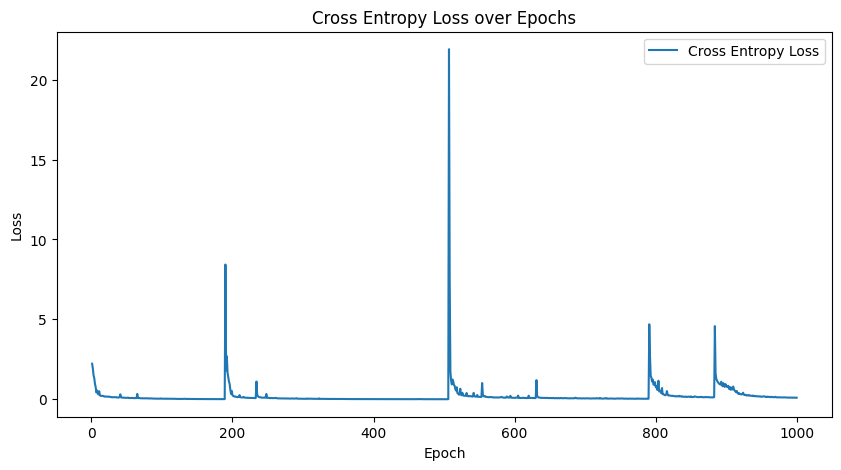

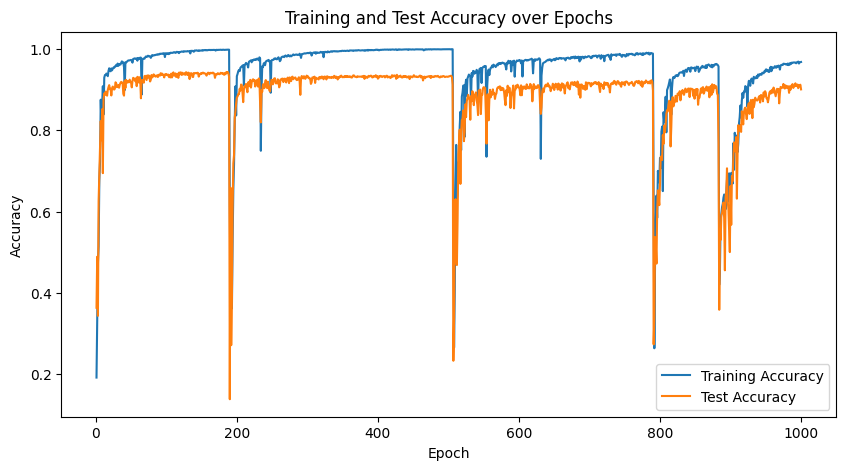

In [5]:
epochs_range = np.arange(1, epochs + 1)
CE_np = CE.cpu().numpy()
Training_np = Training.cpu().numpy()
Test_np = Test.cpu().numpy()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, CE_np, label="Cross Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Cross Entropy Loss over Epochs")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, Training_np, label="Training Accuracy")
plt.plot(epochs_range, Test_np, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()
plt.show()